### Importing Libraries

In [11]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score,ConfusionMatrixDisplay
import pandas as pd

import optuna


## Modelling
### 1. CatBoost

##### Loading Datasets

In [12]:
X_train_res = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/X_train_res.csv')
X_test = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/X_test.csv')
X_val = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/X_val.csv')
y_train_res = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/y_train_res.csv')
y_test = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/y_test.csv')
y_val = pd.read_csv('/Users/nandaniyadav/McGill MMA/Winter 2024/INSY 695/Group Project/customer_churn_2024/data/y_val.csv')

In [13]:
# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=200)

# Train the model with resampled train and test data
catboost_model.fit(X_train_res, y_train_res)

0:	learn: 0.5718870	total: 5.28ms	remaining: 5.27s
200:	learn: 0.0241605	total: 733ms	remaining: 2.91s
400:	learn: 0.0101332	total: 1.46s	remaining: 2.19s
600:	learn: 0.0061180	total: 2.12s	remaining: 1.41s
800:	learn: 0.0049831	total: 2.73s	remaining: 678ms
999:	learn: 0.0047172	total: 3.39s	remaining: 0us


Validation Recall: 0.9319148936170213
Validation Report:               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1386
           1       0.91      0.93      0.92       235

    accuracy                           0.98      1621
   macro avg       0.95      0.96      0.95      1621
weighted avg       0.98      0.98      0.98      1621

Validation Accuracy: 0.9765576804441702


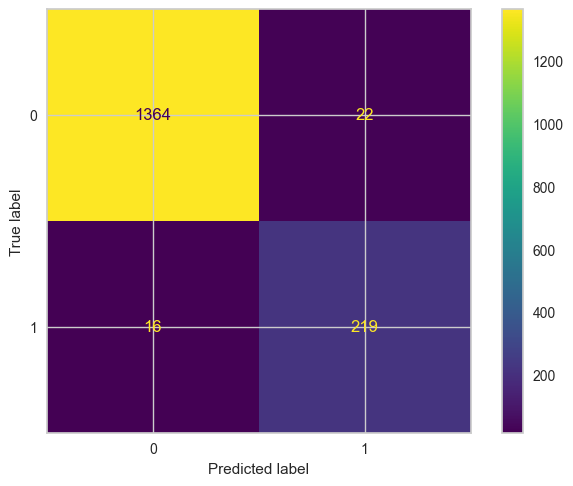

In [32]:
# predicting and evaluating model on validation set
y_val_pred = catboost_model.predict(X_val)
val_recall = recall_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f'Validation Recall: {val_recall}')
print(f'Validation Report: {val_report}')
print(f'Validation Accuracy: {val_accuracy}')

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)


Recall: 0.9113149847094801
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.89      0.91      0.90       327

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



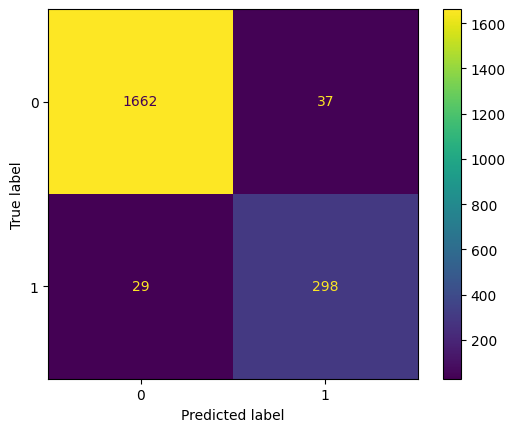

In [20]:
# Predicting on the test set
#y_pred = catboost_model.predict(X_test)

# Evaluating the model
#recall = recall_score(y_test, y_pred)
#report = classification_report(y_test, y_pred)

#print(f"Recall: {recall}")
#print(report)

# confusion matrix on test set
#ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Hyper Parameter Tuning


# 1. using Gridsearch CV

In [15]:
from sklearn.model_selection import GridSearchCV

# Define the model
model = CatBoostClassifier(verbose=0)  # Turn off verbose to suppress detailed output for each fit

# Define the parameters grid to search
param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)

# Fit the grid search to the data
final_model_cat_grid = grid_search.fit(X_train_res, y_train_res)

# After fitting, you can get the best parameters and the best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_parameters}")
print(f"Best score: {best_score}")

Best parameters: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.01}
Best score: 0.9671283471837491


Validation Recall: 0.9319148936170213
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1386
           1       0.88      0.93      0.91       235

    accuracy                           0.97      1621
   macro avg       0.94      0.96      0.95      1621
weighted avg       0.97      0.97      0.97      1621



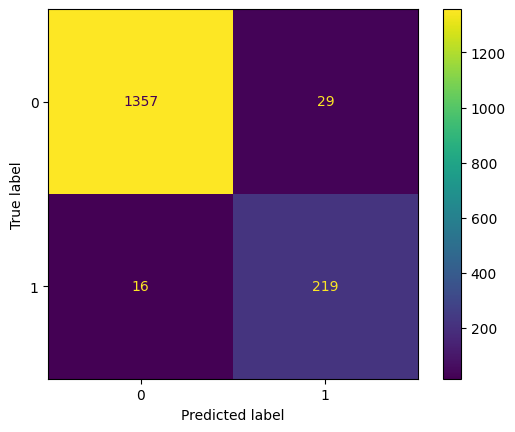

In [21]:
# Retrieve the best parameters and fit the model again
model_with_best_params = CatBoostClassifier(**best_parameters, verbose=0)
model_with_best_params.fit(X_train_res, y_train_res)

# Predict on the validation set
y_val_pred = model_with_best_params.predict(X_val)

# Evaluate the performance
val_recall_grid = recall_score(y_val, y_val_pred)
val_classification_report_grid = classification_report(y_val, y_val_pred)

print(f"Validation Recall: {val_recall_grid}")
print(f"Validation Classification Report:\n{val_classification_report_grid}")

# confusion matrix on test set
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

# 2. using Optuna

In [18]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 50, 200),
        'loss_function': 'Logloss',
        'eval_metric': 'Recall',  
        'verbose': False
    }

    model = CatBoostClassifier(**param)
    model.fit(X_train_res, y_train_res, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-02-19 20:34:54,959] A new study created in memory with name: no-name-e32dd651-c1d1-44b0-bc34-b2e1eb2fb7e9
[I 2024-02-19 20:34:56,079] Trial 0 finished with value: 0.9765576804441702 and parameters: {'iterations': 737, 'learning_rate': 0.25797412145621396, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 170}. Best is trial 0 with value: 0.9765576804441702.
[I 2024-02-19 20:34:56,671] Trial 1 finished with value: 0.8260333127698951 and parameters: {'iterations': 777, 'learning_rate': 0.049727790694761936, 'depth': 5, 'l2_leaf_reg': 4, 'border_count': 112}. Best is trial 0 with value: 0.9765576804441702.
[I 2024-02-19 20:34:57,128] Trial 2 finished with value: 0.769895126465145 and parameters: {'iterations': 595, 'learning_rate': 0.08774816783103173, 'depth': 4, 'l2_leaf_reg': 1, 'border_count': 113}. Best is trial 0 with value: 0.9765576804441702.
[I 2024-02-19 20:34:57,573] Trial 3 finished with value: 0.9068476249228871 and parameters: {'iterations': 800, 'learning_rate': 0.06639

Number of finished trials: 100
Best trial: {'iterations': 649, 'learning_rate': 0.2568567081947971, 'depth': 4, 'l2_leaf_reg': 3, 'border_count': 180}


Validation Recall after Optuna Tuning: 0.9276595744680851
Validation Classification Report after Optuna Tuning:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1386
           1       0.91      0.93      0.92       235

    accuracy                           0.98      1621
   macro avg       0.95      0.96      0.95      1621
weighted avg       0.98      0.98      0.98      1621



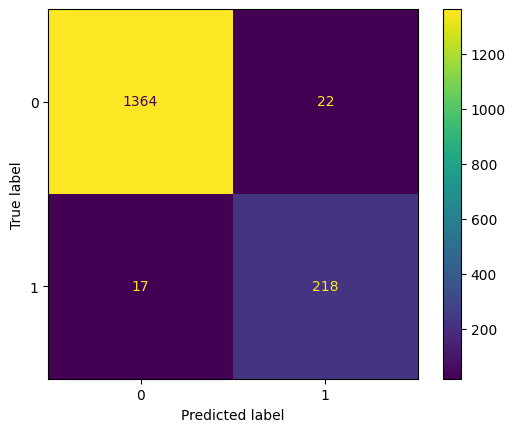

In [19]:
# Train the model using the best parameters
best_params = study.best_trial.params
model_optuna = CatBoostClassifier(**best_params, verbose=0)
model_optuna.fit(X_train_res, y_train_res)

# Predict and evaluate on the validation set
y_val_pred_optuna = model_optuna.predict(X_val)
recall_optuna = recall_score(y_val, y_val_pred_optuna)
classification_report_optuna = classification_report(y_val, y_val_pred_optuna)

print(f"Validation Recall after Optuna Tuning: {recall_optuna}")
print(f"Validation Classification Report after Optuna Tuning:\n{classification_report_optuna}")

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_optuna)

### F beta Score

In [37]:
from sklearn.metrics import fbeta_score

# Predict on the validation set
y_val_pred = model_optuna.predict(X_val)

# Calculate the F-beta score
beta = 2
f_beta = fbeta_score(y_val, y_val_pred, beta=beta)

print(f'F-beta score (beta={beta}): {f_beta}')


F-beta score (beta=2): 0.923728813559322


## PR Curve

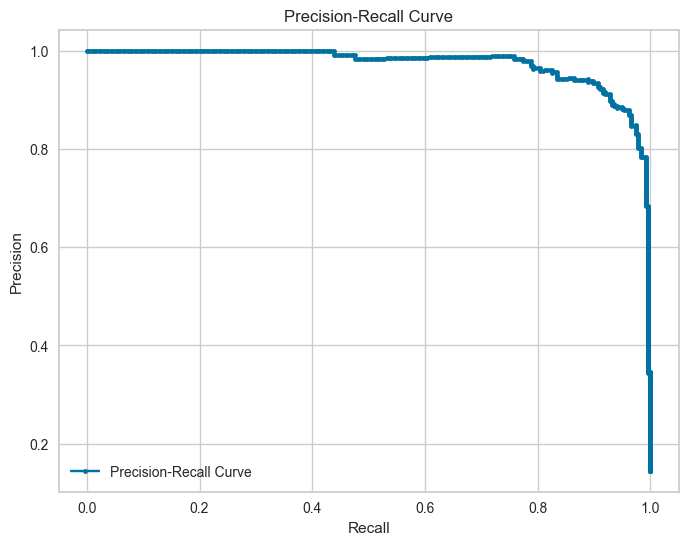

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming y_val are your true labels and model_optuna is your trained model
y_scores = model_optuna.predict_proba(X_val)[:, 1]  # get the probabilities of the positive class

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()


#### ROC - AUC Curve

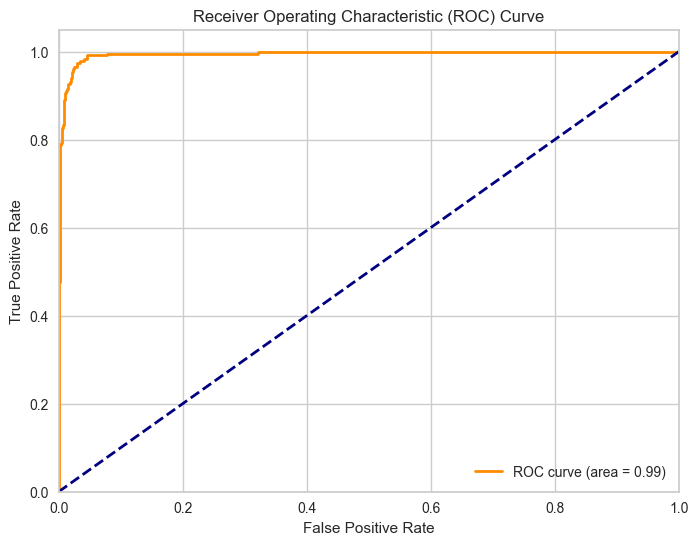

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = roc_auc_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Predicting on Test Set

Test Recall after Optuna Tuning: 0.908256880733945
Test Classification Report after Optuna Tuning:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.89      0.91      0.90       327

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



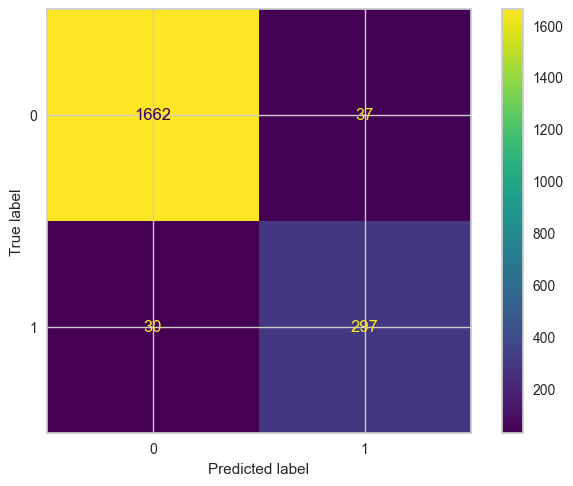

In [38]:
#predicting on test set
y_test_pred = model_optuna.predict(X_test)
test_recall = recall_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Test Recall after Optuna Tuning: {test_recall}")
print(f"Test Classification Report after Optuna Tuning:\n{test_classification_report}")

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

## Checking for overfitting

In [44]:
    # from sklearn.model_selection import learning_curve
    # import numpy as np
    # import matplotlib.pyplot as plt

    # train_sizes, train_scores, test_scores = learning_curve(
    #     model_optuna, X_train_res, y_train_res, cv=5, scoring='recall', n_jobs=-1, 
    #     train_sizes=np.linspace(0.01, 1.0, 50))

    # # Calculate mean and standard deviation for training set scores
    # train_mean = np.mean(train_scores, axis=1)
    # train_std = np.std(train_scores, axis=1)

    # # Calculate mean and standard deviation for test set scores
    # test_mean = np.mean(test_scores, axis=1)
    # test_std = np.std(test_scores, axis=1)

    # plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    # plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # plt.plot(train_sizes, train_mean, label="Training score")
    # plt.plot(train_sizes, test_mean, label="Cross-validation score")

    # plt.title("Learning Curve")
    # plt.xlabel("Training Set Size"), plt.ylabel("Recall Score"), plt.legend(loc="best")
    # plt.tight_layout()
    # plt.show()


### Leaning Curve (F2 Score)

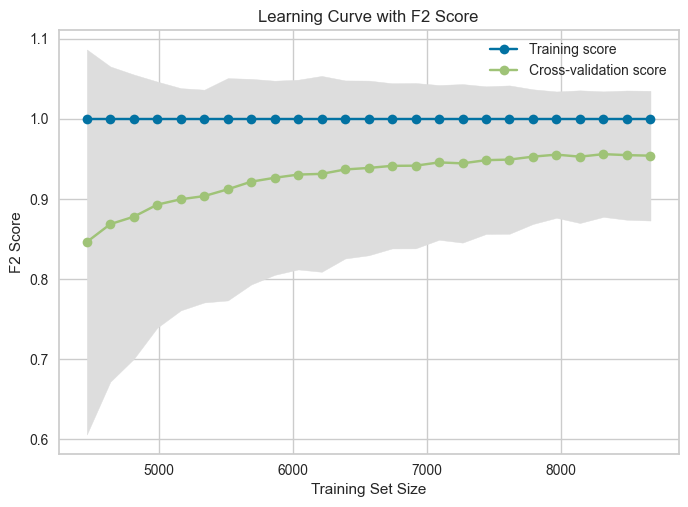

In [41]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define a custom scorer for the F2 score. Set beta=2.
f2_scorer = make_scorer(fbeta_score, beta=2)

# Compute the learning curve with the custom F2 scorer
train_sizes, train_scores, test_scores = learning_curve(
    model_optuna, X_train_res, y_train_res, 
    cv=5, 
    scoring=f2_scorer,
    n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50)
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve with F2 Score")
plt.xlabel("Training Set Size"), plt.ylabel("F2 Score"), plt.legend(loc="best")
plt.show()


## SHapley Additive exPlanations (SHAP)

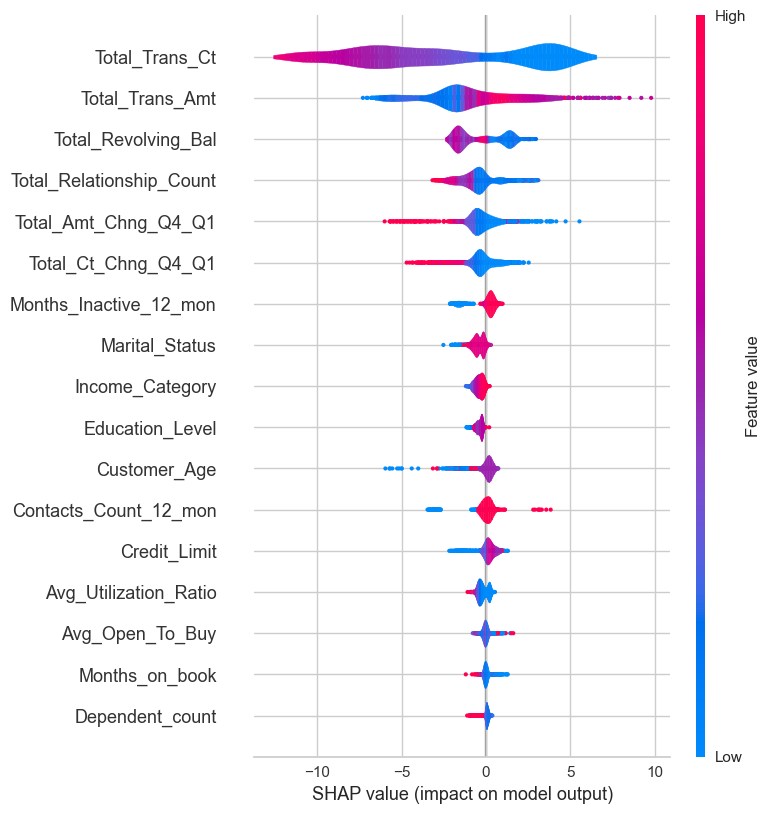

In [43]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_optuna)

# Calculate Shap values for the validation set
shap_values = explainer.shap_values(X_val)

# Plot the SHAP values with a violin plot
shap.summary_plot(shap_values, X_val, plot_type="violin")
